In [1]:
import tensorflow as tf
import keras
import keras.layers as Layers
import keras.losses as Loss
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [4]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Statistical Analysis:

Two types:
1. related to all the words in the dataset (Dataset as a whole entity for statistical examination):
  - Train, Validation and Test split
  - No. of words
  - No. of classes of words
  - Word-class distribution (with plot)
  - No. of types of words (not classes)
  - Average length of the audio (with plot)
  - Words and their corresponding utterances (with plot)

2. related to a single word at random (Random sample/ Example at statical examination):
  - Waveform (plot)
  - Fast Fourier Transform and major frequency(ies) (plot)
  - Spectrogram (plot)
  - MFCC (plot)
  - Mel Spectrogram (plot)
  - No. of vowels and Consonants

In [5]:
# 1. Train, test and validation split
print(len(train_ds), len(test_ds), len(val_ds)) #in batches of size 64 with output sequence length 16000

100 13 12


In [6]:
# 2. No. of files
print((len(train_ds)+len(test_ds)+len(val_ds))*64)

8000


In [7]:
# 3. No of classes and the class labels
num_classes = len(commands)
print(num_classes, commands)

8 ['right' 'no' 'up' 'left' 'go' 'stop' 'down' 'yes']


Counter({1: 814, 4: 814, 7: 806, 0: 801, 6: 799, 3: 791, 2: 791, 5: 784})
Counter({5: 105, 3: 104, 2: 101, 4: 101, 6: 98, 0: 90, 1: 86, 7: 83})
Counter({7: 111, 5: 111, 0: 109, 2: 108, 3: 105, 6: 103, 1: 100, 4: 85})


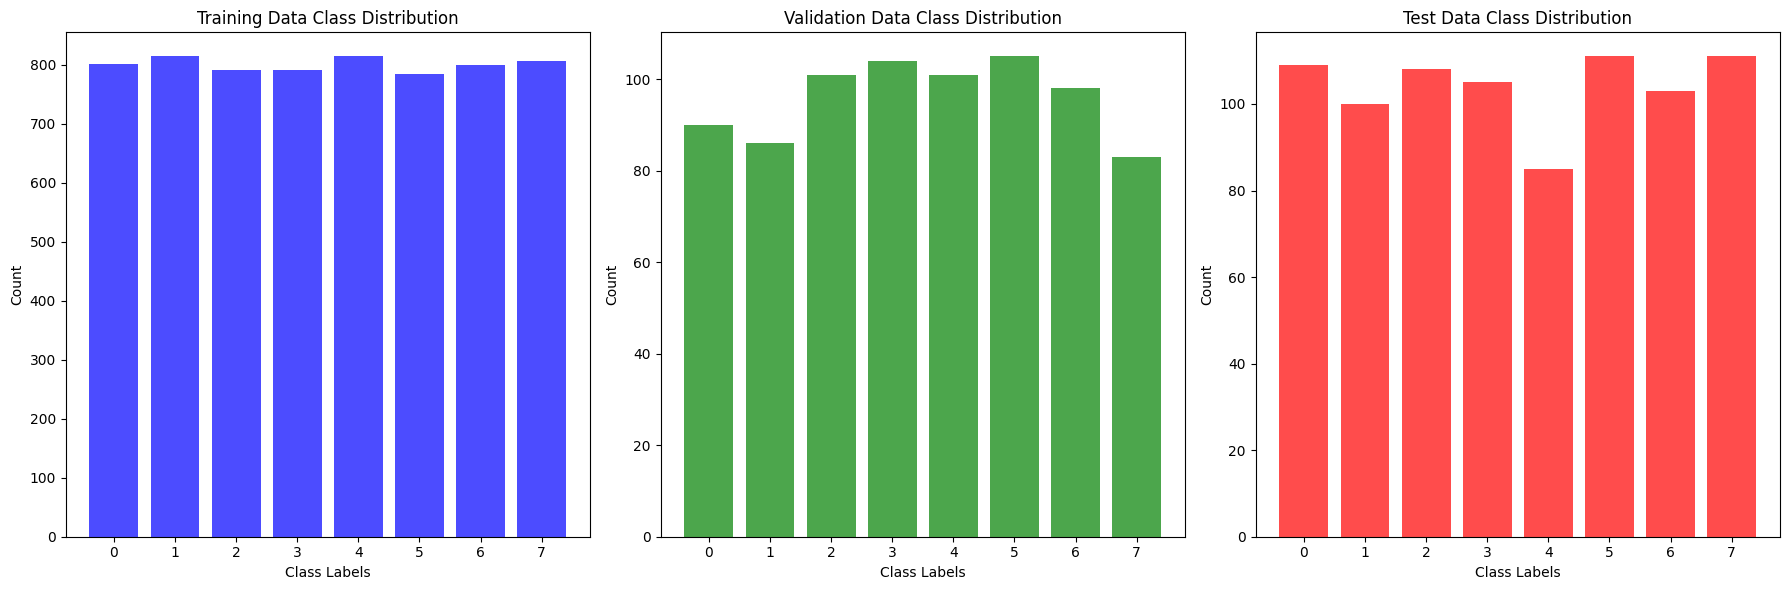

In [8]:
# 4. Word-class Distribution
from collections import Counter
train_dist = Counter(np.concatenate([y.numpy() for x, y in train_ds]))
val_dist = Counter(np.concatenate([y.numpy() for x, y in val_ds]))
test_dist = Counter(np.concatenate([y.numpy() for x, y in test_ds]))
print(train_dist)
print(val_dist)
print(test_dist)

train_labels, train_counts = zip(*sorted(train_dist.items()))
val_labels, val_counts = zip(*sorted(val_dist.items()))
test_labels, test_counts = zip(*sorted(test_dist.items()))

plt.figure(figsize=(18, 6))

# Training data
plt.subplot(1, 3, 1)
plt.bar(train_labels, train_counts, color='b', alpha=0.7)
plt.title('Training Data Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(train_labels)

# Validation data
plt.subplot(1, 3, 2)
plt.bar(val_labels, val_counts, color='g', alpha=0.7)
plt.title('Validation Data Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(val_labels)

# Test data
plt.subplot(1, 3, 3)
plt.bar(test_labels, test_counts, color='r', alpha=0.7)
plt.title('Test Data Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(test_labels)

plt.tight_layout()
plt.show()

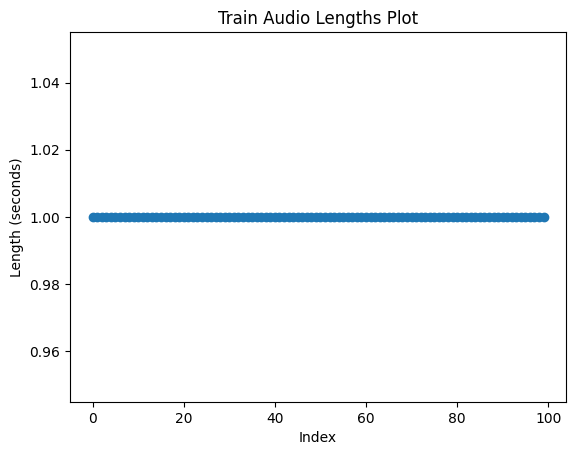

1.0


In [9]:
#5. Audio lengths and Average audio length
def get_audio_lengths(dataset):
    lengths = []
    for audio, _ in dataset:
        lengths.append(audio.shape[1] / 16000)  #16KHz sample rate
    return lengths

lengths = get_audio_lengths(train_ds)

plt.plot(lengths, marker='o')
plt.title('Train Audio Lengths Plot')
plt.xlabel('Index')
plt.ylabel('Length (seconds)')
plt.show()

print(sum(lengths)/len(lengths))

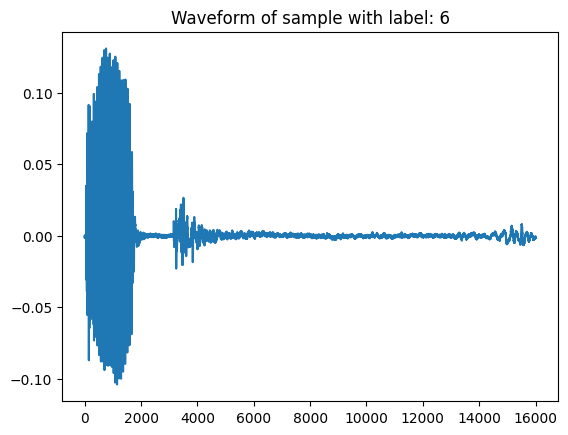

In [10]:
# 2.1 Plot a random waveform
import matplotlib.pyplot as plt

for audio, label in train_ds.take(1):
    plt.plot(audio[0].numpy())
    plt.title(f"Waveform of sample with label: {label[0].numpy()}")
    plt.show()


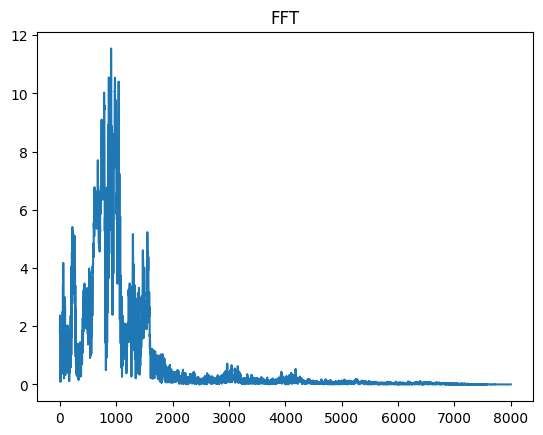

In [11]:
# 2.2 Plot the first half of the FFT (positive frequencies)
def plot_fft(audio, sample_rate=16000):
    fft = tf.signal.fft(tf.cast(audio, tf.complex64))
    plt.plot(np.abs(fft[:len(fft)//2]))
    plt.title("FFT")
    plt.show()

plot_fft(audio[0].numpy())

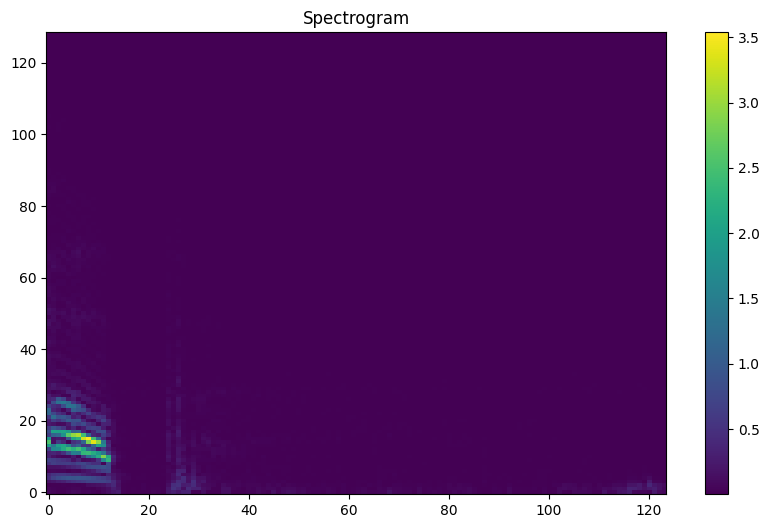

In [12]:
#3. Spectrogram:
def plot_spectrogram(audio, sample_rate=16000):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    plt.figure(figsize=(10, 6))
    plt.imshow(tf.transpose(spectrogram).numpy(), aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.colorbar()
    plt.show()

plot_spectrogram(audio[0].numpy())


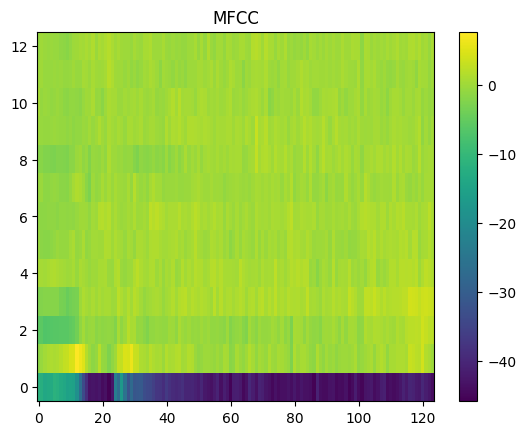

In [13]:
#4. MFCC
def plot_mfcc(audio, sample_rate=16000):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    num_mel_bins = 40
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], sample_rate, 20, 4000)

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :13]

    plt.imshow(tf.transpose(mfcc).numpy(), aspect='auto', origin='lower')
    plt.title('MFCC')
    plt.colorbar()
    plt.show()

plot_mfcc(audio[0].numpy())

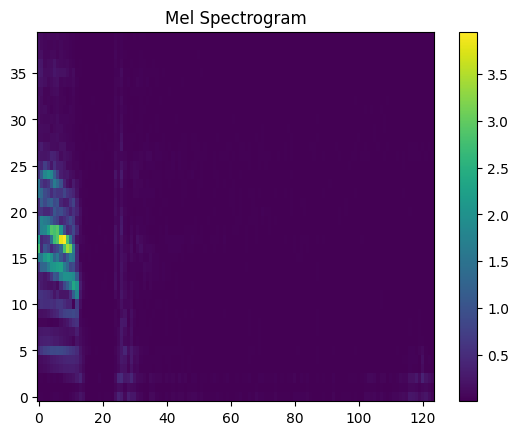

In [14]:
#5. Mel Spectrogram
def plot_mel_spectrogram(audio, sample_rate=16000):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    num_mel_bins = 40
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], sample_rate, 20, 4000)

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)

    plt.imshow(tf.transpose(mel_spectrogram).numpy(), aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.colorbar()
    plt.show()

plot_mel_spectrogram(audio[0].numpy())


In [15]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
num_labels = len(commands)

norm_layer = Layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.Sequential([
    Layers.Input(shape=input_shape),
    Layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    Layers.Conv2D(32, 3, activation='relu'),
    Layers.Conv2D(64, 3, activation='relu'),
    Layers.MaxPooling2D(),
    Layers.Dropout(0.25),
    Layers.Flatten(),
    Layers.Dense(128, activation='relu'),
    Layers.Dropout(0.5),
    Layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [17]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 53s 486ms/step - loss: 1.7514 - accuracy: 0.3666 - val_loss: 1.2820 - val_accuracy: 0.5938
Epoch 2/10
100/100 [==============================] - 26s 263ms/step - loss: 1.1558 - accuracy: 0.5945 - val_loss: 0.8973 - val_accuracy: 0.7214
Epoch 3/10
100/100 [==============================] - 25s 249ms/step - loss: 0.8735 - accuracy: 0.6956 - val_loss: 0.7105 - val_accuracy: 0.7839
Epoch 4/10
100/100 [==============================] - 24s 238ms/step - loss: 0.6982 - accuracy: 0.7527 - val_loss: 0.6422 - val_accuracy: 0.8060
Epoch 5/10
100/100 [==============================] - 25s 250ms/step - loss: 0.5798 - accuracy: 0.7972 - val_loss: 0.5854 - val_accuracy: 0.8099
Epoch 6/10
100/100 [==============================] - 25s 252ms/step - loss: 0.5088 - accuracy: 0.8266 - val_loss: 0.5102 - val_accuracy: 0.8438
Epoch 7/10
100/100 [==============================] - 34s 336ms/step - loss: 0.4404 - accuracy: 0.8489 - val_loss: 0.4697 - val_ac

In [18]:
model.save('data/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
loaded_model = tf.keras.models.load_model('data/my_model.h5')

In [20]:
model.get_weights()

[array([0.12540944], dtype=float32),
 array([0.58403146], dtype=float32),
 102374400,
 array([[[[-0.18042597,  0.02216954,  0.05076506,  0.08503924,
           -0.03493309, -0.28820342, -0.06625488, -0.14067258,
           -0.11451851, -0.14577071, -0.0170001 ,  0.12949984,
            0.18749413,  0.15297605, -0.05969385, -0.16474694,
           -0.2202094 ,  0.17375003,  0.09463267, -0.07889087,
           -0.310108  , -0.07648278, -0.24164812,  0.19719934,
            0.07276873,  0.02316279,  0.14650178, -0.07143436,
            0.24539652,  0.04708688,  0.2539073 ,  0.00761098]],
 
         [[-0.15154889,  0.23349345,  0.1361718 ,  0.20137334,
           -0.03153667, -0.18627624, -0.08529363, -0.17005043,
            0.19268091, -0.08838909,  0.24093154,  0.15617625,
           -0.04129148, -0.10910138, -0.13667203, -0.05497975,
            0.18677352,  0.20717943, -0.12564257, -0.00139534,
           -0.07200535, -0.26044667, -0.13576834,  0.1601185 ,
           -0.1799475 , -0.2

In [21]:
loaded_model.get_weights()

[array([0.12540944], dtype=float32),
 array([0.58403146], dtype=float32),
 102374400,
 array([[[[-0.18042597,  0.02216954,  0.05076506,  0.08503924,
           -0.03493309, -0.28820342, -0.06625488, -0.14067258,
           -0.11451851, -0.14577071, -0.0170001 ,  0.12949984,
            0.18749413,  0.15297605, -0.05969385, -0.16474694,
           -0.2202094 ,  0.17375003,  0.09463267, -0.07889087,
           -0.310108  , -0.07648278, -0.24164812,  0.19719934,
            0.07276873,  0.02316279,  0.14650178, -0.07143436,
            0.24539652,  0.04708688,  0.2539073 ,  0.00761098]],
 
         [[-0.15154889,  0.23349345,  0.1361718 ,  0.20137334,
           -0.03153667, -0.18627624, -0.08529363, -0.17005043,
            0.19268091, -0.08838909,  0.24093154,  0.15617625,
           -0.04129148, -0.10910138, -0.13667203, -0.05497975,
            0.18677352,  0.20717943, -0.12564257, -0.00139534,
           -0.07200535, -0.26044667, -0.13576834,  0.1601185 ,
           -0.1799475 , -0.2

In [22]:
model.evaluate(train_spectrogram_ds)

100/100 [==============================] - 7s 72ms/step - loss: 0.1797 - accuracy: 0.9523


[0.179737851023674, 0.952343761920929]

In [23]:
import random
import numpy as np

labels = ['right', 'no', 'up', 'left', 'go', 'stop', 'down', 'yes']

repeated_labels = labels * 30

random.shuffle(repeated_labels)

print(repeated_labels)

['down', 'right', 'left', 'up', 'up', 'stop', 'go', 'stop', 'up', 'left', 'right', 'left', 'yes', 'up', 'right', 'yes', 'no', 'up', 'no', 'no', 'left', 'up', 'stop', 'left', 'go', 'down', 'up', 'left', 'up', 'down', 'down', 'left', 'yes', 'up', 'stop', 'up', 'right', 'left', 'right', 'stop', 'down', 'left', 'stop', 'right', 'right', 'up', 'right', 'yes', 'no', 'no', 'yes', 'no', 'right', 'stop', 'down', 'right', 'left', 'down', 'stop', 'up', 'yes', 'yes', 'yes', 'go', 'down', 'go', 'up', 'yes', 'yes', 'go', 'no', 'yes', 'no', 'no', 'go', 'left', 'no', 'go', 'no', 'right', 'go', 'no', 'down', 'up', 'no', 'go', 'go', 'no', 'left', 'down', 'no', 'yes', 'down', 'left', 'up', 'stop', 'up', 'go', 'right', 'no', 'up', 'down', 'down', 'no', 'left', 'left', 'no', 'left', 'stop', 'up', 'left', 'go', 'right', 'yes', 'go', 'yes', 'left', 'no', 'left', 'right', 'stop', 'left', 'down', 'yes', 'stop', 'left', 'yes', 'right', 'no', 'go', 'left', 'yes', 'stop', 'up', 'down', 'stop', 'yes', 'yes', 'no',

In [24]:
!pip install sounddevice wave

In [ ]:
import sounddevice as sd
import wave
import os
import random
import time

labels = ['right', 'no', 'up', 'left', 'go', 'stop', 'down', 'yes']
dictionary = {'right': 1, 'no': 2, 'up': 3, 'left': 4, 'go': 5, 'stop': 6, 'down': 7, 'yes': 8}
repeated_labels = labels * 30
random.shuffle(repeated_labels)

output_dir = 'recordings'
duration = 1  # seconds
sample_rate = 16000
no_labels = len(repeated_labels)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in range(no_labels):
    label = repeated_labels[i]
    print(f"{label}")
    time.sleep(1)
    print("recording")
    audio = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=1, dtype='int16')
    sd.wait()

    sd.play(audio, samplerate=sample_rate)
    sd.wait()
    time.sleep(1)

    filename = os.path.join(output_dir, f"{i}.wav")
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio.tobytes())

    print(f"Saved recording for {label} to {filename}")

print("All recordings are complete.")

with open(os.path.join(output_dir,'labels.txt'), 'w') as lf:
    for label in repeated_labels:
        lf.write(f"{dictionary[label]}\n")


In [25]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [26]:
!pip install spicy

In [27]:
import tensorflow as tf
import os
import numpy as np
from scipy.io import wavfile

record_dir = '/drive/MyDrive/recordings'
label_file = os.path.join(record_dir, 'labels.txt')

with open(label_file, 'r') as f:
    labels = f.read().splitlines()

labels = [int(label) for label in labels]

file_paths = [os.path.join(record_dir, f"{i + 1}.wav") for i in range(len(labels))]

target_length = 16000

def load_wav(file_path, label):
    sample_rate, audio = wavfile.read(file_path)
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)

    audio = audio / np.max(np.abs(audio))

    if tf.shape(audio)[0] < target_length:
        padding = target_length - tf.shape(audio)[0]
        audio = tf.pad(audio, [[0, padding]])
    else:
        audio = audio[:target_length]

    audio = tf.expand_dims(audio, axis=0)
    audio = tf.expand_dims(audio, axis=0)

    return audio, label

dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

dataset = dataset.map(lambda file_path, label: tf.py_function(load_wav, [file_path, label], [tf.float32, tf.int32]))

dataset = dataset.map(lambda audio, label: (tf.ensure_shape(audio, [None, target_length, None]), tf.ensure_shape(label, [])))

dataset = dataset.shuffle(buffer_size=len(labels)).batch(64)


In [31]:
def reshape_audio(audio, label):
    audio = tf.reshape(audio, [target_length])
    return audio, label

dataset = dataset.map(lambda audio, label: tf.py_function(reshape_audio, [audio, label], [tf.float32, tf.int32]))

dataset = dataset.map(lambda audio, label: (tf.ensure_shape(audio, [16000, ]), tf.ensure_shape(label, [])))

dataset = dataset.shuffle(buffer_size=len(labels)).batch(64)


In [32]:
dataset


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [72]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [77]:
dataset_spectrogram_ds = make_spec_ds(dataset)

In [70]:
train_spectrogram_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

dataset_spectrogram_ds = make_spec_ds(dataset)
train_spectrogram_ds = make_spec_ds(train_ds)
dataset_spectrogram_ds = dataset_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
dataset_spectrogram_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
train_spectrogram_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model.evaluate(dataset_spectrogram_ds)

In [ ]:
from keras_tuner import HyperParameters

def tuned_model(hp):
    model = models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(hp_units, activation='relu', input_shape=(784,)))

    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    model.add(layers.Dense(10, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    tuned_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_val = x_val.reshape(-1, 28 * 28).astype('float32') / 255.0

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

best_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))